In [37]:
from tqdm import tqdm
tqdm.pandas()
from glob import glob

import json
import csv
import numpy as np
import pandas as pd
from collections import Counter

import rdflib
from rdflib import Graph
from data.data import CollectionAccessor, ImageHandler

from search import Search, Randomiser

In [2]:
def init_DMG():
    image_folder = "./data/images/DMG"
    image_handler = ImageHandler(image_folder=image_folder, keep_prefix=False)
    print("image paths loaded...")

    time_stamp, pub_file, priv_file = CollectionAccessor.get_latest_dump("./data/dumps")
    print(CollectionAccessor.get_latest_dump("./data/dumps"))

    
    dmg_meta = dict(name="Design Museum Gent (public & private)", id_="DMG_"+time_stamp,
                creation_timestamp=time_stamp)
    df = CollectionAccessor.get_DMG(pub_path=pub_file, #get_latest("./data/dumps", contains="public"),
                                     priv_path=priv_file, #get_latest("./data/dumps", contains="private"),
                                     rights_path="./data/rights.csv",
                                     image_handler=image_handler,
                                     **dmg_meta)
    
    rand = Randomiser(df, name="Randomiser")
    rand2 = Randomiser(df, name="Randomiser")
    s = Search([rand, rand2])
    return image_handler, df, s

im, dmg, dmg_search = init_DMG()

image paths loaded...
./data/dumps/API_dump_public_2025-05-13.json ./data/dumps/API_dump_private_2025-05-13.json
./data/dumps/API_dump_public_2025-05-13.json ./data/dumps/API_dump_private_2025-05-13.json
('2025-05-13', './data/dumps/API_dump_public_2025-05-13_extracted.csv', './data/dumps/API_dump_private_2025-05-13_extracted.csv')


100%|████████████████████████████████| 24824/24824 [00:36<00:00, 677.21it/s]


In [20]:
recs = dmg.sample(4)
searcher_ids = [s.id for s in dmg_search.searchers[:1]]

In [24]:
dmg_search(recs, searcher_ids=searcher_ids)

object_number
1992-0004_0-2    0.776923
1992-0004_1-2    0.357817
1992-0004_2-2    0.667643
4521             0.466348
5051             0.770696
                   ...   
2022-0028        0.341355
2022-0025_0-3    0.363114
2022-0025_1-3    0.415226
2022-0025_2-3    0.771660
2022-0025_3-3    0.559759
Length: 24824, dtype: float64

---
# DEV FUNCTIONS

In [ ]:
def search_collection(collection_id, object_ids, concept, model_list):
    cur_coll = get_collection(collection_id)
    object_ids = parse_id_list(object_ids)
    model_list = parse_id_list(model_list)
    cur_search = searches[collection_id]
    print(object_ids)
    scores = cur_search(object_ids)


object_ids = "1987-0120_04-14,1987-1343_2-4,3370,3703_0-2"
object_ids = parse_id_list(object_ids)
object_ids
recs = dmg.loc[object_ids]

In [ ]:
# searcher_scores = [cur_s(recs) for cur_s in dmg_search.searchers]
# searcher_scores = pd.DataFrame({cur_s.name: cur_s for cur_s in searcher_scores})
# searcher_scores.loc[recs.index] = 0.


# searcher_scores.round(3)

In [52]:


dmg.coll.filter("doos")

,object_URI,title,description,objectname_URI,objectname_label,subcollection_URI,subcollection_type,subcollection_name,material_URI,material_label,...,coiner_URI,coiner_label,acquisition_time,is_public,Unnamed: 0,rights,attribution,image_path,time,sort_rank
object_number,,,,,,,,,,,,,,,,,,,,,
1978-0057,https://stad.gent/id/mensgemaaktobject/dmg/530...,echtpaar in park,Er is een fragment afgebroken dat in zijdepapi...,[http://vocab.getty.edu/aat/300258857],[waaier],[],[],[],[],[],...,[],[],1978,False,3367.0,CC0 1.0,NaN,NaN,1765~/1780~,2276
1047,https://stad.gent/id/mensgemaaktobject/dmg/530...,Cloissoné doos met bloemen en figuren in een i...,Polychroom smaltwerk op koper. Het deksel toon...,[http://vocab.getty.edu/aat/300045643],[doos (houder)],[],[],[],[http://vocab.getty.edu/aat/300011020],[koper],...,[],[],NaN,False,1208.0,Copyright Status Not Evaluated,NaN,NaN,1800/1899,2655
1122,https://stad.gent/id/mensgemaaktobject/dmg/530...,Cloissoné doos met landschap en interieur,smaltwerk op koper,[http://vocab.getty.edu/aat/300045643],[doos (houder)],[],[],[],[http://vocab.getty.edu/aat/300011020],[koper],...,[],[],NaN,False,1342.0,Copyright Status Not Evaluated,NaN,NaN,1800/1899,2666
1987-0387,https://stad.gent/id/mensgemaaktobject/dmg/530...,NaN,NaN,[https://stad.gent/id/concept/530000312],[loddereindoosje],[],[],[],"[http://vocab.getty.edu/aat/300011029, http://...","[zilver, metaal]",...,[],[],1987,False,5775.0,CC0 1.0,NaN,NaN,1858/,3793
1987-0701_7-7,https://stad.gent/id/mensgemaaktobject/dmg/530...,NaN,NaN,"[http://vocab.getty.edu/aat/300055100, http://...","[productverpakking, doos (houder)]",[https://stad.gent/id/mensgemaaktobject/dmg/53...,[],[],[],[],...,[],[],1987,False,6442.0,CC0 1.0,NaN,NaN,1861/1896,3964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-0174_0,https://stad.gent/id/mensgemaaktobject/dmg/530...,NaN,14 onderdelen waarvan 13 losse stukken marmer ...,[http://vocab.getty.edu/aat/300052347],[schoorsteenmantel],[],[],[],[http://vocab.getty.edu/aat/300011443],[marmer],...,[https://stad.gent/id/agent/530000720],"[Van huffel, Albert]",2017,False,NaN,NaN,NaN,NaN,2017,24509
2017-0174_1,https://stad.gent/id/mensgemaaktobject/dmg/530...,NaN,14 onderdelen waarvan 13 losse stukken marmer ...,[http://vocab.getty.edu/aat/300052347],[schoorsteenmantel],[],[],[],[http://vocab.getty.edu/aat/300011443],[marmer],...,[https://stad.gent/id/agent/530000720],"[Van huffel, Albert]",2017,False,NaN,NaN,NaN,NaN,2017,24510
2017-0212,https://stad.gent/id/mensgemaaktobject/dmg/530...,lampenkap + doos met verlichtingselementen,Muller,[http://vocab.getty.edu/aat/300037592],[lamp],[https://stad.gent/id/concept/530010876],[https://www.projectcest.be/wiki/Publicatie:In...,[],[],[],...,[https://stad.gent/id/agent/530013363],"[Henderick, Geo]",2017,False,17034.0,Copyright Status Not Evaluated,NaN,NaN,2017,24541


---
# TESTING ROUTES

In [25]:
!curl "http://0.0.0.0:8080/collections"

[{"id":"DMG_2025-05-13","name":"Design Museum Gent (public & private)"}]

In [26]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13"

{"name":"Design Museum Gent (public & private)","id_":"DMG_2025-05-13","creation_timestamp":"2025-05-13","number_of_records":24824}

In [27]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13/object-details?object_ids=1987-0120_04-14,1987-1343_2-4,3370,3703_0-2"

[{"inventory_number":"1987-0120_04-14","title":"Ijslepeltje","description":"","designer":"","producer":"J.M. van Kempen en Zonen","design_date":"","production_date":"na 1907","design_place":"","production_place":"Nederland","rights_attribution":"In Copyright","image_path":""},{"inventory_number":"1987-1343_2-4","title":"","description":"","designer":"","producer":"Alice Van Mourik","design_date":"","production_date":"","design_place":"","production_place":"","rights_attribution":"In Copyright","image_path":""},{"inventory_number":"3370","title":"","description":"","designer":"","producer":"","design_date":"","production_date":"","design_place":"","production_place":"","rights_attribution":"In Copyright","image_path":""},{"inventory_number":"3703_0-2","title":"","description":"","designer":"","producer":"","design_date":"","production_date":"","design_place":"","production_place":"","rights_attribution":"In Copyright","image_path":""}]

In [28]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13/models"

[{"id":140406639262368,"name":"Randomiser"},{"id":140406541666400,"name":"Randomiser"}]

In [29]:
!curl "http://0.0.0.0:8080/moon?ISO_8601_datetime=2024-05-13&lat_degrees=51.05&long_degrees=3.71"

0.15026621349345307

In [32]:
# default params for search
!curl "http://0.0.0.0:8080/DMG_2025-05-13/search"

{"1992-0004_0-2":4.0283596519497264e-05,"1992-0004_1-2":4.0283596519497264e-05,"1992-0004_2-2":4.0283596519497264e-05,"4521":4.0283596519497264e-05,"5051":4.0283596519497264e-05,"5052":4.0283596519497264e-05,"5055":4.0283596519497264e-05,"5057_1-2":4.0283596519497264e-05,"5057_2-2":4.0283596519497264e-05,"5056":4.0283596519497264e-05,"0901":4.0283596519497264e-05,"0977":4.0283596519497264e-05,"0980":4.0283596519497264e-05,"0008":4.0283596519497264e-05,"0832":4.0283596519497264e-05,"0833":4.0283596519497264e-05,"0834":4.0283596519497264e-05,"0836":4.0283596519497264e-05,"0843":4.0283596519497264e-05,"0844":4.0283596519497264e-05,"0847":4.0283596519497264e-05,"0848":4.0283596519497264e-05,"0849":4.0283596519497264e-05,"0850":4.0283596519497264e-05,"0855":4.0283596519497264e-05,"0856":4.0283596519497264e-05,"0864":4.0283596519497264e-05,"0867":4.0283596519497264e-05,"0870":4.0283596519497264e-05,"0872":4.0283596519497264e-05,"0873":4.0283596519497264e-05,"0875":4.0283596519497264e-05,"087

In [33]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13/search?object_ids="1987-0120_04-14,1987-1343_2-4,3370,3703_0-2"&concept="hello"&model_list="a,b""

{"1992-0004_0-2":4.0283596519497264e-05,"1992-0004_1-2":4.0283596519497264e-05,"1992-0004_2-2":4.0283596519497264e-05,"4521":4.0283596519497264e-05,"5051":4.0283596519497264e-05,"5052":4.0283596519497264e-05,"5055":4.0283596519497264e-05,"5057_1-2":4.0283596519497264e-05,"5057_2-2":4.0283596519497264e-05,"5056":4.0283596519497264e-05,"0901":4.0283596519497264e-05,"0977":4.0283596519497264e-05,"0980":4.0283596519497264e-05,"0008":4.0283596519497264e-05,"0832":4.0283596519497264e-05,"0833":4.0283596519497264e-05,"0834":4.0283596519497264e-05,"0836":4.0283596519497264e-05,"0843":4.0283596519497264e-05,"0844":4.0283596519497264e-05,"0847":4.0283596519497264e-05,"0848":4.0283596519497264e-05,"0849":4.0283596519497264e-05,"0850":4.0283596519497264e-05,"0855":4.0283596519497264e-05,"0856":4.0283596519497264e-05,"0864":4.0283596519497264e-05,"0867":4.0283596519497264e-05,"0870":4.0283596519497264e-05,"0872":4.0283596519497264e-05,"0873":4.0283596519497264e-05,"0875":4.0283596519497264e-05,"087

In [35]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13/search/order?object_ids="1987-0120_04-14,1987-1343_2-4,3370,3703_0-2"&concept="hello"&model_list="a,b"&skip=200&limit=100&reverse=true"

[{"inventory_number":"0989","title":"Paneel met deurbeslag ","description":"Het geheel bestaat uit 6 verschillende deurhengsels en een grote slotplaat. De onderdelen (mogelijk modellen) zijn vastgemaakt op een plank, waarop een visitekaartje was vastgemaakt waarop de naam \"Ach François Mathieu\" lijkt te staan. Het beslag was al vastgemaakt op de plank voor het door het muse …","designer":"Achiel Carolus François","producer":"","design_date":"","production_date":"ca. 1922 — ca. 1922","design_place":"Gent","production_place":"","rights_attribution":"In Copyright","image_path":""},{"inventory_number":"1409","title":"","description":"","designer":"","producer":"Miyagawa Kozan","design_date":"","production_date":"na 1922","design_place":"Japan","production_place":"","rights_attribution":"In Copyright","image_path":""},{"inventory_number":"1467","title":"","description":"","designer":"","producer":"","design_date":"","production_date":"ca. 1922 — ca. 1922","design_place":"","production_pla

In [37]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13/search/sample?object_ids="1987-0120_04-14,1987-1343_2-4,3370,3703_0-2"&concept="hello"&model_list="a,b"&k=12"

[{"inventory_number":"2256","title":"Gebrocheerde damast","description":"Het onvolledig patroon kan aan de hand van variante stukken beschreven worden. Verspringende horizontale rijen met fantastische planten: in de ene rij: grote bloemen, in de volgende grote vruchten, telkens omvat door een U-vorm. De motieven lopen uit in tal van fijne bloemen- en vruchtentakjes. Van  …","designer":"","producer":"","design_date":"","production_date":"1700 — 1705","design_place":"","production_place":"Frankrijk","rights_attribution":"In Copyright","image_path":""},{"inventory_number":"FH-0094_1-3","title":"2110","description":"Deze theeketel behoort tot een theeservies voor één persoon in verzilverd metaal. Op de buik staat een wapenschildje. Het halfcirkelvormige handvat is omwikkeld met riet.","designer":"Christopher Dresser","producer":"Hukin & Heath","design_date":"na 1879-10-18","production_date":"","design_place":"Londen","production_place":"Birmingham","rights_attribution":"In Copyright","imag

In [55]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13/search/order/filter?object_ids="1987-0120_04-14,1987-1343_2-4,3370,3703_0-2"&concept="hello"&model_ids=""&filter_text="doosje""

[{"inventory_number":"FH-0092","title":"Zeshoekig doosje met lakwerkversiering","description":"Marcel Wolfers is de zoon van Philippe Wolfers, de hoofdontwerper bij de bekende Brusselse firma Wolfers Frères. Net als zijn vader is hij beeldhouwer  en ontwerper van luxueuze voorwerpen. Hij legt zich in het bijzonder toe op lakwerk volgens de arbeidsintensieve Japanse techniek.\r\n\r\nDeze zeshoekig …","designer":"Marcel Wolfers","producer":"Lakatelier Marcel Wolfers","design_date":"","production_date":"ca. 1930 — ca. 1932","design_place":"","production_place":"Brussel","rights_attribution":"In Copyright","image_path":""}]

---

In [ ]:
import requests as rq
base = "http://0.0.0.0:8080/"
path = "moon"
for d in range(10, 30):
    q = dict(ISO_8601_datetime=f"2024-05-{d}", lat_long_degrees="51.05,3.71")
    print(q)
    resp = rq.get(base+path, params=q)
    
    print(resp.json())

In [59]:
dmg.columns

Index(['object_URI', 'title', 'description', 'objectname_URI',
       'objectname_label', 'subcollection_URI', 'subcollection_type',
       'subcollection_name', 'material_URI', 'material_label', 'part_label',
       'part_material_URI', 'part_material_label', 'creation_time',
       'creation_place_URI', 'creation_place_label', 'maker_URI',
       'maker_label', 'technique_URI', 'technique_label', 'coin_time',
       'coin_place_URI', 'coin_place_label', 'coiner_URI', 'coiner_label',
       'acquisition_time', 'is_public', 'Unnamed: 0', 'rights', 'attribution',
       'image_path', 'time', 'sort_rank'],
      dtype='object')

---
## resizing images

In [38]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [39]:
from data.data import ImageHandler

ih = ImageHandler("./data/images/DMG/")

In [59]:
def smaller(w, h):
    fixed_size = 1200
    r = h/w 
    if w >= h:
        return (fixed_size, int(fixed_size*r))
    else:
        r = 1/r
        return (int(fixed_size*r), fixed_size)

# def resize(img):
#     new_w, new_h = smaller(*img.size)
#     img.thumbnail((new_w, new_h), Image.Resampling.LANCZOS)

def get_resized(path):
    with Image.open(path) as img_handle:
        new_size = smaller(*img_handle.size)
        img.thumbnail(new_size, Image.Resampling.LANCZOS)
        import os
os.makedirs(new_p)
        path.replace
# sizes = ih._obj.progress_apply(get_resized)
sizes = pd.DataFrame([list(get_resized(p)) for path_ls in tqdm(ih._obj) for p in path_ls], columns=["w", "h"])

100%|████████████████████████████████████████████████████████████████████████| 23382/23382 [01:42<00:00, 227.96it/s]


In [68]:
p = ih._obj.iloc[0][0]

new_p = p.replace("data/images/DMG", "data/images/DMG_resized")

import os
os.makedirs(new_p)

FileExistsError: [Errno 17] File exists: './data/images/DMG_resized/0001_0-2/0001$2.JPG'

In [31]:

def smaller(w, h):
    fixed_size = 1200
    r = h/w 
    if w > h:
        return (fixed_size, fixed_size*r)
    else:
        r = 1/r
        return (fixed_size*r, fixed_size)

def resize(img):
    new_w, new_h = smaller(*img.size)
    img.thumbnail((new_w, new_h))

In [32]:
resize(img)
img.save("test.jpg", quality=90)

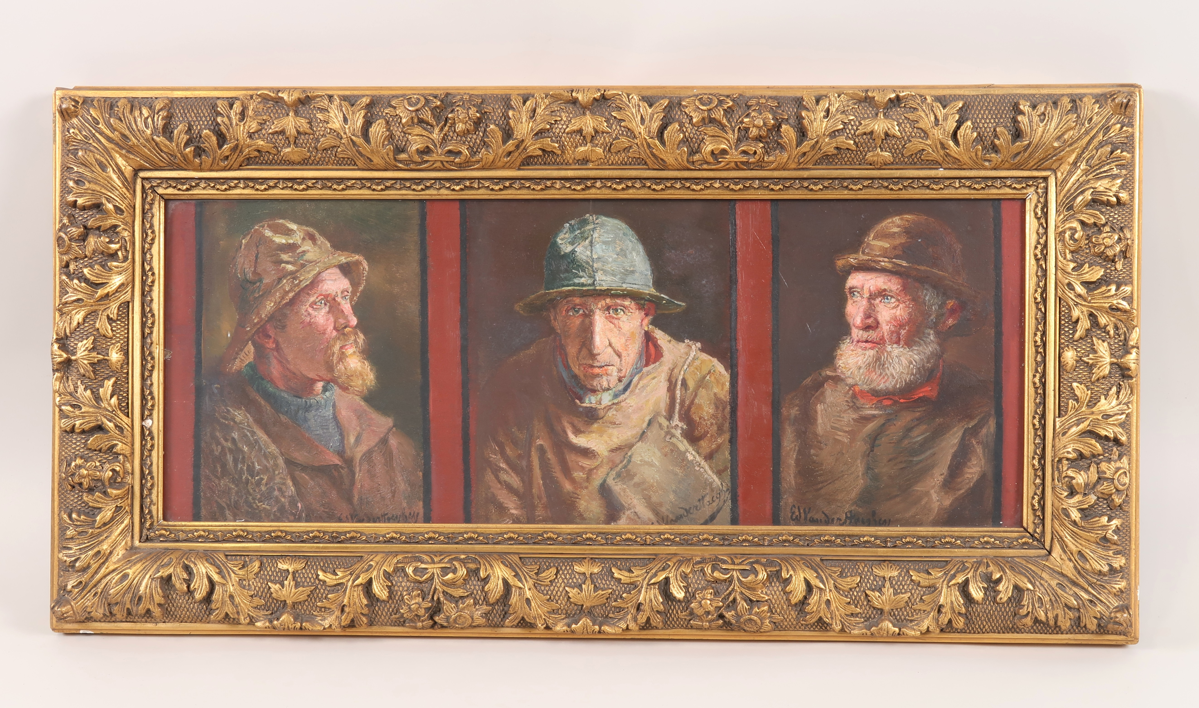

In [33]:
img

In [35]:
img2 = Image.open("test.jpg")

img2.size

(1199, 708)

In [36]:
img2.close()